<a href="https://www.kaggle.com/code/samithsachidanandan/indian-bird-species-detection-cnn?scriptVersionId=291497849" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf 
from tensorflow.keras import layers, models


2026-01-12 17:17:23.077830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768238243.498690      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768238243.623957      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768238244.613078      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768238244.613119      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768238244.613122      23 computation_placer.cc:177] computation placer alr

In [3]:


train_dir = Path('/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
def proc_img(filepath):
  

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

   
    df = pd.concat([filepath, labels], axis=1)

 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 25916

Number of different labels: 25

Labels: ['Common_Myna' 'Common_Tailorbird' 'Sarus_Crane' 'Jungle_Babbler'
 'Ruddy_Shelduck' 'Common_Rosefinch' 'Hoopoe' 'Gray_Wagtail'
 'Rufous_Treepie' 'House_Crow' 'Indian_Peacock' 'Indian_Roller'
 'Red_Wattled_Lapwing' 'White_Wagtail' 'Coppersmith_Barbet'
 'Northern_Lapwing' 'Indian_Grey_Hornbill' 'White_Breasted_Kingfisher'
 'Forest_Wagtail' 'Cattle_Egret' 'Asian_Green_Bee_eater'
 'White_Breasted_Waterhen' 'Common_Kingfisher' 'Indian_Pitta'
 'Brown_Headed_Barbet']


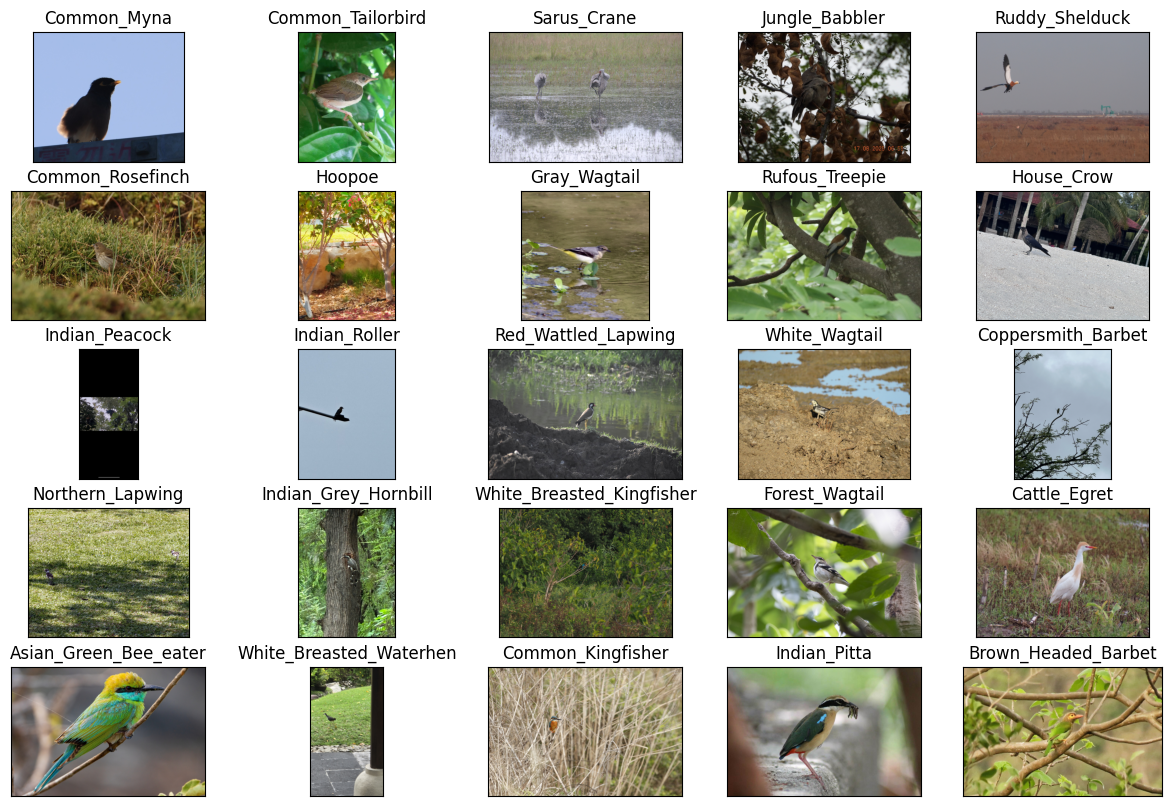

In [6]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 8
SEED = 42
VAL_SPLIT = 0.2


In [8]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training"
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation"
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 29556 files belonging to 25 classes.
Using 23645 files for training.


I0000 00:00:1768238350.862797      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768238350.866706      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 29556 files belonging to 25 classes.
Using 5911 files for validation.
Found 7402 files belonging to 25 classes.


In [9]:
class_names = train_ds_raw.class_names
num_classes = len(class_names)

In [10]:
batch = next(train_ds_raw.as_numpy_iterator())

In [11]:
batch[0].shape

(8, 128, 128, 3)

In [12]:
class_names = train_ds_raw.class_names
print(class_names)

['Asian_Green_Bee_eater', 'Brown_Headed_Barbet', 'Cattle_Egret', 'Common_Kingfisher', 'Common_Myna', 'Common_Rosefinch', 'Common_Tailorbird', 'Coppersmith_Barbet', 'Forest_Wagtail', 'Gray_Wagtail', 'Hoopoe', 'House_Crow', 'Indian_Grey_Hornbill', 'Indian_Peacock', 'Indian_Pitta', 'Indian_Roller', 'Jungle_Babbler', 'Northern_Lapwing', 'Red_Wattled_Lapwing', 'Ruddy_Shelduck', 'Rufous_Treepie', 'Sarus_Crane', 'White_Breasted_Kingfisher', 'White_Breasted_Waterhen', 'White_Wagtail']


In [13]:
train_ds = train_ds_raw.map(lambda x, y: (x/255,y))
test_ds = test_ds_raw.map(lambda x, y: (x/255,y))
val_ds = val_ds_raw.map(lambda x, y: (x/255,y))

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = test_ds.cache().prefetch(AUTOTUNE)
test_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
input_shape = batch[0].shape[1:]
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),   

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,769 (483.47 KB)

 Trainable params: 123,001 (480.47 KB)

 Non-trainable params: 768 (3.00 KB)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7
)

In [20]:
history = model.fit(
    train_ds,
    epochs=100,               
    validation_data=val_ds, 
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1768238371.445401      81 service.cc:152] XLA service 0x7f33a002b990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768238371.445437      81 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768238371.445441      81 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768238372.263051      81 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-12 17:19:34.937405: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 17:19:35.080889: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 17:19:35.718024: E external/local_xl

   8/2956 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.0684 - loss: 3.8710

I0000 00:00:1768238380.562412      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2954/2956 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0731 - loss: 3.4246

2026-01-12 17:21:42.959358: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 17:21:43.102326: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 17:21:43.648484: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 17:21:43.911344: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2956/2956 ━━━━━━━━━━━━━━━━━━━━ 179s 56ms/step - accuracy: 0.0731 - loss: 3.4244 - val_accuracy: 0.0969 - val_loss: 3.2139 - learning_rate: 0.0010
Epoch 2/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.1130 - loss: 2.9903 - val_accuracy: 0.1162 - val_loss: 3.0563 - learning_rate: 0.0010
Epoch 3/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.1438 - loss: 2.8790 - val_accuracy: 0.1455 - val_loss: 3.0043 - learning_rate: 0.0010
Epoch 4/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.1650 - loss: 2.8045 - val_accuracy: 0.1716 - val_loss: 2.9227 - learning_rate: 0.0010
Epoch 5/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.1920 - loss: 2.7215 - val_accuracy: 0.2048 - val_loss: 2.8351 - learning_rate: 0.0010
Epoch 6/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.2205 - loss: 2.6217 - val_accuracy: 0.2116 - val_loss: 3.0102 - learning_rate: 0.0010
Epoch 7/100
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 

In [21]:
scores = model.evaluate(test_ds)

926/926 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3845 - loss: 2.2951


In [22]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 36.27%


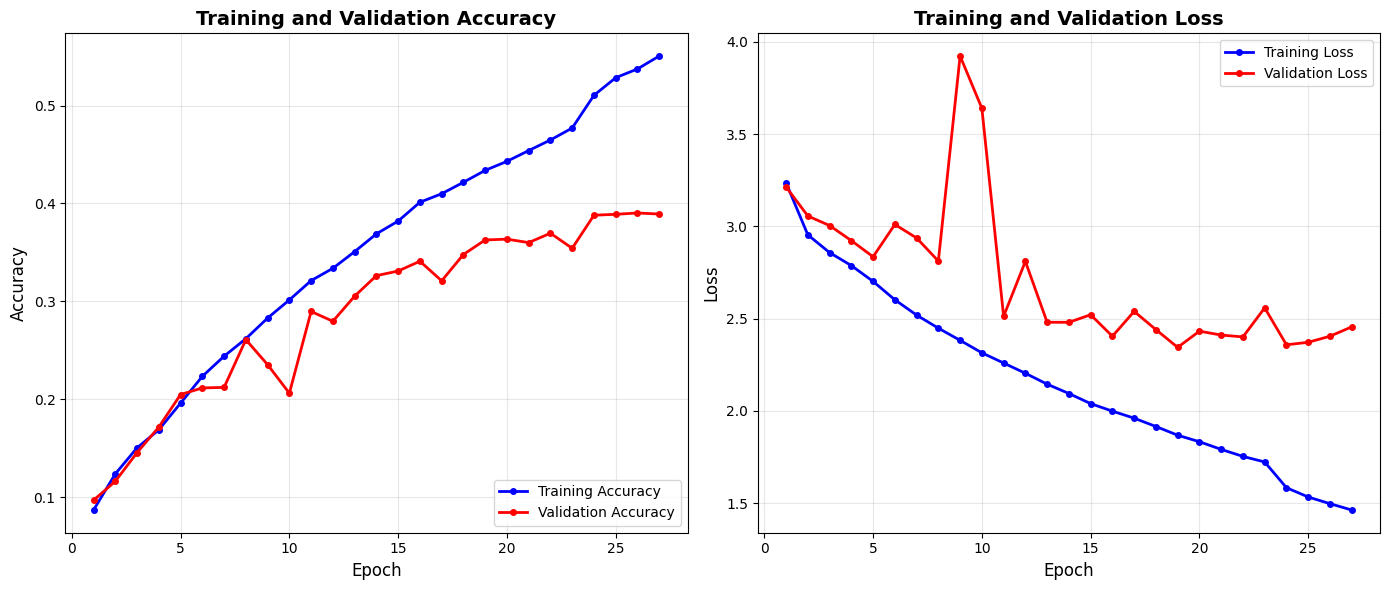


Training Summary:
Total epochs trained: 27
Best validation accuracy: 0.3903 (Epoch 26)
Final training accuracy: 0.5506
Final validation accuracy: 0.3892
Final training loss: 1.4625
Final validation loss: 2.4551



In [23]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)